<a href="https://colab.research.google.com/github/sugmos/project14/blob/main/sug81_ngs_ru_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="http://s3.amazonaws.com/pix.iemoji.com/images/emoji/apple/ios-12/256/waving-hand.png" align=left width=44, heigth=44>
<div class="alert alert-info">
<b> Комментарий ревьюера</b>


Привет, Сергей! Давай знакомиться! Меня зовут Дмитрий Махортов, и я буду проверять твой проект.

Моя основная цель — не указать на совершенные тобою ошибки, а поделиться своим опытом и помочь тебе погрузиться в увлекательный мир работы с данными и вырасти в крепкого профи. Это отдаленная цель. А ближайшая - сделать твою работу еще лучше )).
   
    
Все ключевые этапы в работе выполнены, и я вижу что с проектом ты справшяешься. Есть моменты, которые нужно доработать, но я уверен, у тебя все получится.
        
Расскажу как обычно проходит проверка:    
Бывают моменты, которые требуют пристального внимания. Комментарии по ним выделены <span style='background-color:#F7B3A4'> красным цветом </span> и обозначены значком 🛑. После их доработки проект будет принят.  🙂

<span style='background-color:#B7EBA7'> Зеленым цветом </span> и значком ✅ отмечены удачные и элегантные решения, на которые можно опираться в будущих проектах. Или советы «со звездочкой», которые помогут тебе в будущем.

<span style='background-color:#F9EDA6'>Жёлтым цветом </span> и значком ⚠️ выделено то, что в следующий раз можно сделать по-другому. Ты можешь учесть эти комментарии при выполнении будущих заданий или доработать проект сейчас (однако это не обязательно).

Давай работать над проектом в диалоге: **если ты что-то меняешь в проекте по моим рекомендациям — пиши об этом**. Выбери для своих комментариев какой-то заметный цвет, так мне будет легче отследить изменения. Пожалуйста, **не перемещай, не изменяй и не удаляй мои комментарии**. Всё это поможет выполнить повторную проверку твоего проекта оперативнее.
</div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">
    <font size="3"><b>образец комментария студента</b></font>
   
Можешь использовать этот комментарий. Просто удали этот текст и вместо него напиши свой 🙂

</div>

## Постановка задачи

Необходимо разработать демонстрационную версию поиска изображений по текстовому запросу.<br>
Для демонстрационной версии нужно обучить модель, которая получит векторное представление изображения, векторное представление текста, а на выходе выдаст число от 0 до 1 — покажет, насколько текст и картинка подходят друг другу.

### Описание данных

В файле `train_dataset.csv` находится информация, необходимая для обучения: имя файла изображения, идентификатор описания и текст описания. Для одной картинки может быть доступно до 5 описаний. Идентификатор описания имеет формат `<имя файла изображения>#<порядковый номер описания>`.

В папке `train_images` содержатся изображения для тренировки модели.

В файле `CrowdAnnotations.tsv` — данные по соответствию изображения и описания, полученные с помощью краудсорсинга.

В файле `ExpertAnnotations.tsv` содержатся данные по соответствию изображения и описания, полученные в результате опроса экспертов.

В файле `test_queries.csv` находится информация, необходимая для тестирования: идентификатор запроса, текст запроса и релевантное изображение. Для одной картинки может быть доступно несколько описаний.

В папке `test_images` содержатся изображения для тестирования модели.

In [1]:
#!pip install keras -q

In [2]:
#!pip install tensorflow -q

In [3]:
#!pip install nltk -q

In [4]:
#!pip install spacy -q

In [5]:
!pip install transformers catboost optuna keras-tuner

In [6]:
#!pip install lightgbm

## Загрузка данных

In [7]:
#!pip install transformers -q

In [8]:

import pandas as pd
import numpy as np
import random
import re
import matplotlib.pyplot as plt
import os

from tqdm.notebook import tqdm
from tqdm import notebook

import spacy
import spacy.cli
import nltk
#import transformers
from nltk.corpus import stopwords

import tensorflow as tf
from tensorflow import keras
from keras import layers
from keras import backend as K
import keras_tuner


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from transformers import BertTokenizer, TFBertModel
from sklearn.model_selection import GroupShuffleSplit, GroupKFold, cross_validate, cross_val_score


import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
import optuna


import pickle


<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Отлично, все нужные библиотеки импортированы в начале ноутбука.Это хорошая практика.</div>

In [9]:
!wget -N https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip
!unzip -uq dsplus_integrated_project_4.zip
print('-' * 100)
!ls

--2023-08-19 18:27:17--  https://code.s3.yandex.net/datasets/dsplus_integrated_project_4.zip
Resolving code.s3.yandex.net (code.s3.yandex.net)... 93.158.134.158, 2a02:6b8::2:158
Connecting to code.s3.yandex.net (code.s3.yandex.net)|93.158.134.158|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘dsplus_integrated_project_4.zip’ not modified on server. Omitting download.

----------------------------------------------------------------------------------------------------
bert_base_uncased		 __MACOSX     to_upload
dsplus_integrated_project_4.zip  sample_data


In [10]:
path = 'to_upload//'
IMG_SHAPE = (224, 224, 3)
N_FOLDS=3
SEED = 43

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Большое тебе человеческое спасибо за вынос пути к данным в отдельную константу. Это сэкономило мне немало времени при проверке.</div>

In [11]:
# 1. Set `PYTHONHASHSEED` environment variable at a fixed value
#os.environ['PYTHONHASHSEED']=str(SEED)

# 2. Set `python` built-in pseudo-random generator at a fixed value
random.seed(SEED)

# 3. Set `numpy` pseudo-random generator at a fixed value
np.random.seed(SEED)

# 4. Set the `tensorflow` pseudo-random generator at a fixed value
tf.compat.v1.set_random_seed(SEED)

# 5. Configure a new global `tensorflow` session
session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [12]:
# загрузка описания для тренировочных данных
train_data = pd.read_csv(path+'train_dataset.csv', sep=',')

# загрузка описания для тестовых данных
test_data = pd.read_csv(path+'test_queries.csv', sep='|', index_col=[0])


In [13]:
train_data.head()

,image,query_id,query_text
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,1262583859_653f1469a9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
2,2447284966_d6bbdb4b6e.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
3,2549968784_39bfbe44f9.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
4,2621415349_ef1a7e73be.jpg,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...


<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
Мне кажется это какие-то "ховсты" экспериментов, скорее всего можно безболезненно удалить</div>

In [14]:
test_data.head()

,query_id,query_text,image
0,1177994172_10d143cb8d.jpg#0,"Two blonde boys , one in a camouflage shirt an...",1177994172_10d143cb8d.jpg
1,1177994172_10d143cb8d.jpg#1,Two boys are squirting water guns at each other .,1177994172_10d143cb8d.jpg
2,1177994172_10d143cb8d.jpg#2,Two boys spraying each other with water,1177994172_10d143cb8d.jpg
3,1177994172_10d143cb8d.jpg#3,Two children wearing jeans squirt water at eac...,1177994172_10d143cb8d.jpg
4,1177994172_10d143cb8d.jpg#4,Two young boys are squirting water at each oth...,1177994172_10d143cb8d.jpg


- 1 - Имя файла изображения.
- 2 - Идентификатор описания.
- 3 - Доля людей, подтвердивших, что описание соответствует изображению.
- 4 - Количество человек, подтвердивших, что описание соответствует изображению.
- 5 - Количество человек, подтвердивших, что описание не соответствует изображению.

In [15]:
# Загрузка данных с Crowd оценки
col_names = ['file_name','id_comment', 'per_agree', 'number_agree', 'number_not_agree' ]

crowd_train = pd.read_csv(path+'CrowdAnnotations.tsv', sep='\t', header=None, names=col_names)

In [16]:
crowd_train.head()

,file_name,id_comment,per_agree,number_agree,number_not_agree
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3,0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0,3
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0,3
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0,3
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0,3


In [17]:
crowd_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47830 entries, 0 to 47829
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   file_name         47830 non-null  object 
 1   id_comment        47830 non-null  object 
 2   per_agree         47830 non-null  float64
 3   number_agree      47830 non-null  int64  
 4   number_not_agree  47830 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.8+ MB


1- Имя файла изображения.
2- Идентификатор описания.
3, 4, 5 — оценки трёх экспертов.

Эксперты ставят оценки по шкале от 1 до 4, где:
* 1 — изображение и запрос совершенно не соответствуют друг другу
* 2 — запрос содержит элементы описания изображения, но в целом запрос тексту не соответствует
* 3 — запрос и текст соответствуют с точностью до некоторых деталей
* 4 — запрос и текст соответствуют полностью.

In [18]:
# Загрузка данных экспертной оценки
col_names = ['file_name','id_comment','exp1', 'exp2', 'exp3']

expert_train = pd.read_csv(path+'ExpertAnnotations.tsv', sep='\t', header=None, names=col_names)

In [19]:
expert_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5822 entries, 0 to 5821
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   file_name   5822 non-null   object
 1   id_comment  5822 non-null   object
 2   exp1        5822 non-null   int64 
 3   exp2        5822 non-null   int64 
 4   exp3        5822 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 227.5+ KB


In [20]:
# посчитаем количество уникальных комментариев
len(list(expert_train['id_comment'].unique()))

977

In [21]:
expert_train.head()

,file_name,id_comment,exp1,exp2,exp3
0,1056338697_4f7d7ce270.jpg,2549968784_39bfbe44f9.jpg#2,1,1,1
1,1056338697_4f7d7ce270.jpg,2718495608_d8533e3ac5.jpg#2,1,1,2
2,1056338697_4f7d7ce270.jpg,3181701312_70a379ab6e.jpg#2,1,1,2
3,1056338697_4f7d7ce270.jpg,3207358897_bfa61fa3c6.jpg#2,1,2,2
4,1056338697_4f7d7ce270.jpg,3286822339_5535af6b93.jpg#2,1,1,2


In [22]:
datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = datagen.flow_from_dataframe(
        dataframe=train_data[['image','query_text']].sample(100, random_state=SEED),
        directory=path + '/train_images',
        x_col='image',
        y_col='query_text',
        target_size=(320, 320),
        batch_size=10,
        class_mode='raw',
        subset=None,
        shuffle=True,
        seed=SEED)

test_gen_flow = datagen.flow_from_dataframe(
        dataframe=test_data[['image','query_text']].sample(100, random_state=SEED),
        directory=path + '/test_images',
        x_col='image',
        y_col='query_text',
        target_size=(320, 320),
        batch_size=10,
        class_mode='raw',
        subset=None,
        shuffle=True,
        seed=SEED)

Found 100 validated image filenames.
Found 100 validated image filenames.


In [23]:
def img_randprint(generator, img_rows, img_columns, fig_title, btch_space=1, btch_size=1):

    '''btch_space может быть (generator.samples//btch_size +1)'''

    fig, ax = plt.subplots(img_rows, img_columns, figsize=(img_columns*8, img_rows*3))
    for i in range(img_rows*img_columns):
        batch_num = np.random.randint(btch_space)
        img_num = np.random.randint(btch_size)
        generator.reset()
        for _ in range(batch_num):
            fch, target = next(generator)
        ax[i//img_columns][i%img_columns].imshow(fch[img_num])
        ax[i//img_columns][i%img_columns].set_title(str(target[img_num]), fontsize=12)
        ax[i//img_columns][i%img_columns].axis ('off')
    fig.suptitle(fig_title, y=0.95, fontsize=18)
    plt.show()

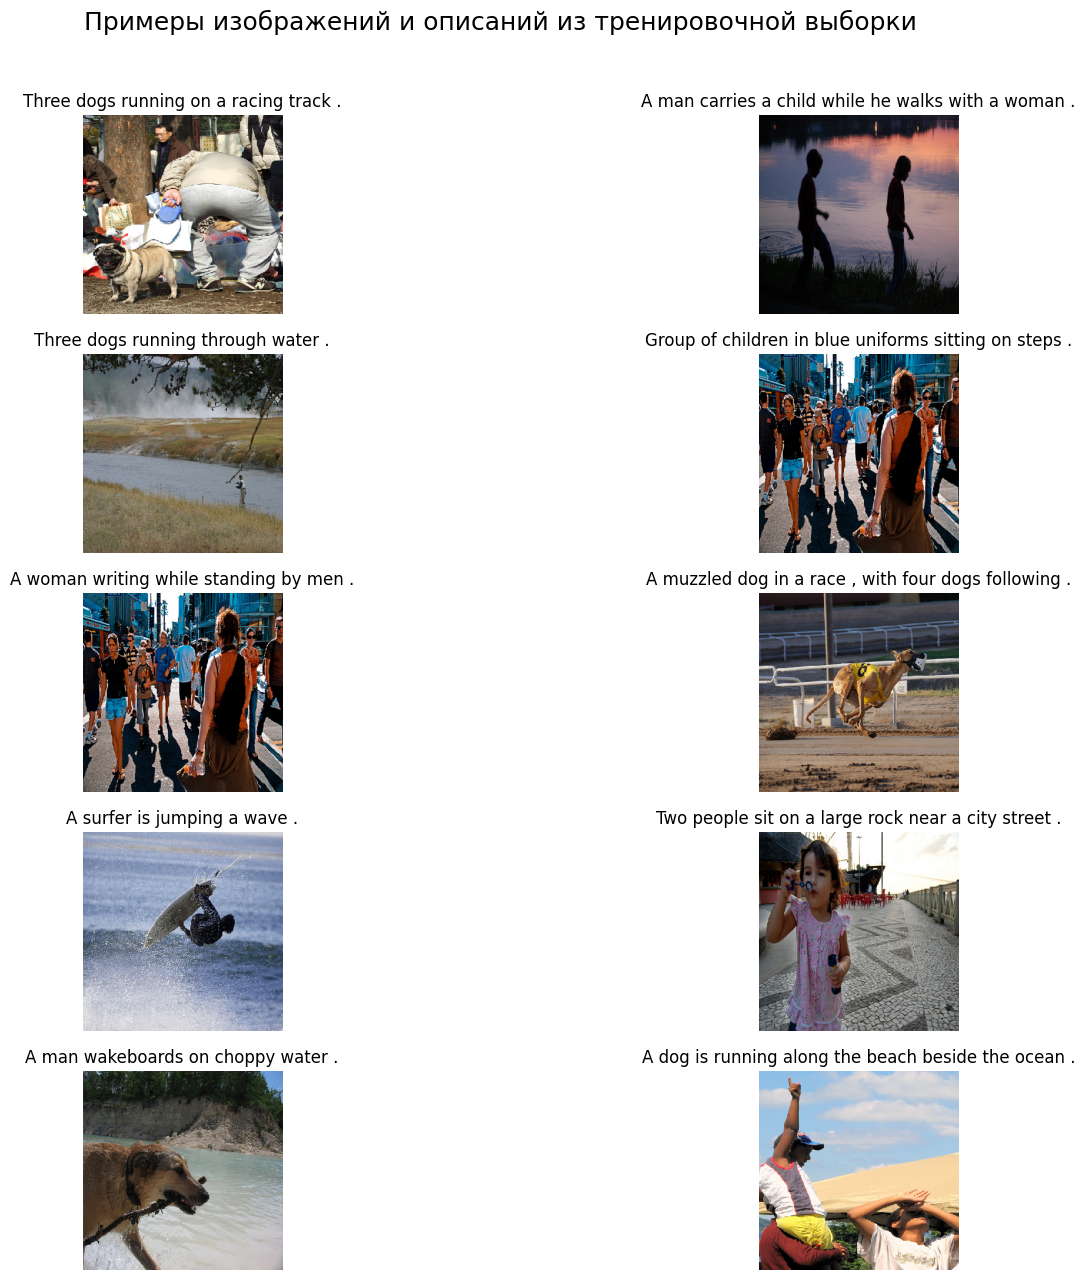

In [24]:
img_randprint(train_gen_flow,
              5, 2,
              'Примеры изображений и описаний из тренировочной выборки',
              train_gen_flow.samples//10,
              10)

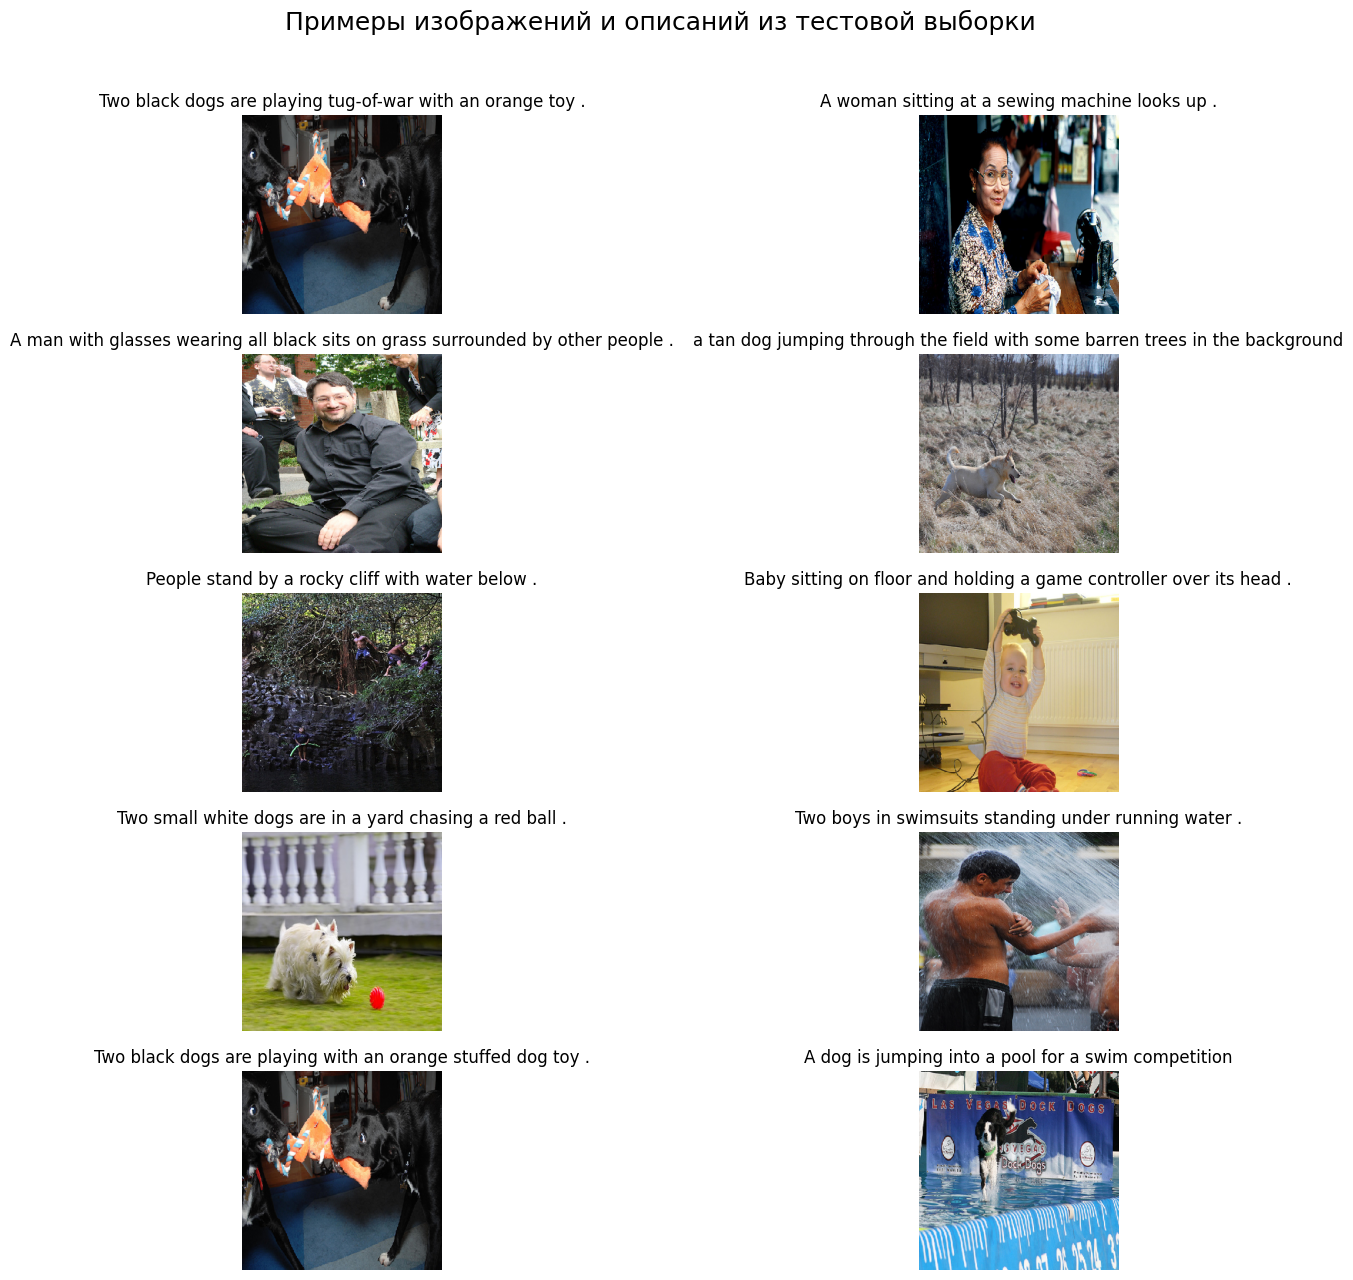

In [25]:
img_randprint(test_gen_flow,
              5, 2,
              'Примеры изображений и описаний из тестовой выборки',
              test_gen_flow.samples//10, 10)

In [26]:
del test_gen_flow, train_gen_flow

**Выводы:**
 1. Данные в обучающей выборке имеют большое количество описаний которые не соответсвуют изображениям
 2. Описание для тестовых изображений более точные

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
ОК, вижуты загрузил данные и познакомился с ними</div>

## Анализ данных

In [27]:
# проверим уникальные сочетания комментариев
exp_scores = list(zip(expert_train['exp1'], expert_train['exp2'], expert_train['exp3']))
pd.Series(exp_scores).unique()

array([(1, 1, 1), (1, 1, 2), (1, 2, 2), (2, 2, 2), (1, 2, 3), (2, 3, 3),
       (2, 2, 3), (3, 3, 3), (2, 3, 4), (4, 4, 4), (3, 4, 4), (3, 3, 4),
       (1, 3, 3), (1, 1, 3), (2, 4, 4), (2, 2, 4), (1, 2, 4), (1, 4, 4)],
      dtype=object)

Есть варианты противоположных оценок вида (1,2,4) удалим такие записи так как они не улучшать качество обучения

In [28]:

toxic_scores = [ item for item in exp_scores if (np.max(item) - np.min(item))>2 ]
toxic_index = [i for i, x in enumerate(exp_scores) if x == toxic_scores[0]]
print(toxic_scores)
print(toxic_index)
expert_train.loc[toxic_index]



[(1, 2, 4), (1, 2, 4), (1, 4, 4)]
[3956, 5561]


,file_name,id_comment,exp1,exp2,exp3
3956,3388330419_85d72f7cda.jpg,3358558292_6ab14193ed.jpg#2,1,2,4
5561,542179694_e170e9e465.jpg,300577375_26cc2773a1.jpg#2,1,2,4


<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
Оценка 1, 4, 4 мне кажется вполне валидной. Два эксперта решили что изображение соответствует описанию, а один мог просто ошибиться.


А вот оценки, где эксперты не смогли договориться явно подлежать удалению.
</div>

In [29]:
expert_train = expert_train.drop(toxic_index)
del toxic_index

In [30]:
# соединим данные по crowd оценкам с данными экспертрных оценок

new_df = pd.merge(crowd_train, expert_train,  how='outer', left_on=['file_name', 'id_comment'],
                  right_on = ['file_name', 'id_comment'])


<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
После создания новых таблиц (или сложных преобразований старых, которые могут изменять количество записей) стоит показывать что получилось и не только через вывод строк, но показывая размерности. В этом смысле крайне полезной будет "пара" head + info.
</div>

In [31]:
# подготовим словарь уникальных комментариев
train_dict = train_data[['query_id', 'query_text']].copy().drop_duplicates().reset_index(drop=True)
train_dict

,query_id,query_text
0,2549968784_39bfbe44f9.jpg#2,A young child is wearing blue goggles and sitt...
1,2718495608_d8533e3ac5.jpg#2,A girl wearing a yellow shirt and sunglasses s...
2,3181701312_70a379ab6e.jpg#2,A man sleeps under a blanket on a city street .
3,3207358897_bfa61fa3c6.jpg#2,A woman plays with long red ribbons in an empt...
4,3286822339_5535af6b93.jpg#2,Chinese market street in the winter time .
...,...,...
972,2061144717_5b3a1864f0.jpg#2,A man in an ampitheater talking to a boy .
973,2196107384_361d73a170.jpg#2,a old man walks down the uncrowded road .
974,2112921744_92bf706805.jpg#2,A dog stands on the side of a grassy cliff .
975,3651971126_309e6a5e22.jpg#2,A blurry photo of two dogs .


In [32]:
# Добавим текст комментария в сводный датасет
new_df = pd.merge(new_df, train_dict, how='left', left_on=['id_comment'], right_on = ['query_id'])

In [33]:
#проверим пропуски
new_df.isna().sum()

file_name               0
id_comment              0
per_agree            3491
number_agree         3491
number_not_agree     3491
exp1                45501
exp2                45501
exp3                45501
query_id             1109
query_text           1109
dtype: int64

**Вывод** получилось что для 1109 записей нет текстового значения комментария. Для дальнейшего анализа эти данные бесполезны. Удалим их из датасета. 3491 запись не содержит данных по crowd оценкам и  45501 записей не содержат данных по экспертным оценкам.

In [34]:
# удалим данные без тектового комментария
new_df = new_df.dropna(subset=['query_id'], axis=0)
new_df.isna().sum()

file_name               0
id_comment              0
per_agree            3491
number_agree         3491
number_not_agree     3491
exp1                44392
exp2                44392
exp3                44392
query_id                0
query_text              0
dtype: int64

Сводный "сырой" датасет

In [35]:
new_df.head()

,file_name,id_comment,per_agree,number_agree,number_not_agree,exp1,exp2,exp3,query_id,query_text
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3.0,0.0,NaN,NaN,NaN,1056338697_4f7d7ce270.jpg#2,"A woman is signaling is to traffic , as seen f..."
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0.0,3.0,NaN,NaN,NaN,114051287_dd85625a04.jpg#2,A boy in glasses is wearing a red shirt .
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0.0,3.0,NaN,NaN,NaN,1427391496_ea512cbe7f.jpg#2,A young boy holds onto a blue handle on a pier .
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0.0,3.0,NaN,NaN,NaN,2073964624_52da3a0fc4.jpg#2,"A woman wearing black clothes , a purple scarf..."
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0.0,3.0,NaN,NaN,NaN,2083434441_a93bc6306b.jpg#2,An older woman with blond hair rides a bicycle...


<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
Не стоит выводить весь датафрейм. Да, внешне ты видишь первые и последние пять строк. Но под капотом интерпретатор python работает со всем датафреймом, занимается оперативная память, пишутся служебные файлы... По итогу это может привести к замедлению работы и проблемам с работоспособностью тетрадки.
    
Лучше всегда явно ограничивать количество обрабатываемых значений.
</div>

Введем нормализованный "индекс соответствия" для экспертов, который будем вычислять как: $$\frac{(exp_1 + exp_2 + exp_3) -3}{9}$$

In [36]:
new_df = new_df.assign(exp_rate=lambda x: ((x.exp1 + x.exp2 + x.exp3) - 3) / 9)
new_df.head(5)

,file_name,id_comment,per_agree,number_agree,number_not_agree,exp1,exp2,exp3,query_id,query_text,exp_rate
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,3.0,0.0,NaN,NaN,NaN,1056338697_4f7d7ce270.jpg#2,"A woman is signaling is to traffic , as seen f...",NaN
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,0.0,3.0,NaN,NaN,NaN,114051287_dd85625a04.jpg#2,A boy in glasses is wearing a red shirt .,NaN
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,0.0,3.0,NaN,NaN,NaN,1427391496_ea512cbe7f.jpg#2,A young boy holds onto a blue handle on a pier .,NaN
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,0.0,3.0,NaN,NaN,NaN,2073964624_52da3a0fc4.jpg#2,"A woman wearing black clothes , a purple scarf...",NaN
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,0.0,3.0,NaN,NaN,NaN,2083434441_a93bc6306b.jpg#2,An older woman with blond hair rides a bicycle...,NaN


In [37]:
# формирование масок пустых значений
exp_mask = ~np.isnan(new_df["exp_rate"])
crowd_mask = ~np.isnan(new_df["per_agree"])
both_mask = exp_mask & crowd_mask

In [38]:
#расчет сводного индекса

experts_rate_only_indx = (exp_mask & ~crowd_mask)[exp_mask & ~crowd_mask].index
new_df.loc[experts_rate_only_indx, "sum_rate"] = new_df.loc[
    experts_rate_only_indx, "exp_rate"
]

crowd_rate_only_indx = (~exp_mask & crowd_mask)[~exp_mask & crowd_mask].index
new_df.loc[crowd_rate_only_indx, "sum_rate"] = new_df.loc[
    crowd_rate_only_indx, "per_agree"
]

both_indx = (both_mask)[both_mask].index
new_df.loc[both_indx, "sum_rate"] = (
    new_df.loc[both_indx, "exp_rate"] * 0.6
    + new_df.loc[both_indx, "per_agree"] * 0.4
)

new_df = new_df.drop(columns=['exp_rate', 'per_agree', 'number_agree', 'number_not_agree',
                              'exp1', 'exp2', 'exp3','id_comment'])
new_df.head()

,file_name,query_id,query_text,sum_rate
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,"A woman is signaling is to traffic , as seen f...",1.0
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,A boy in glasses is wearing a red shirt .,0.0
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,A young boy holds onto a blue handle on a pier .,0.0
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,"A woman wearing black clothes , a purple scarf...",0.0
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,An older woman with blond hair rides a bicycle...,0.0


**Вывод:**
   1. Текст описания на английсокм языке
   2. Есть знаки припинания

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
ОК, получен сводный датафрейм и выведена итоговая оценка на основе доступных. Молодец, что использовал все доступные данные.</div>

## Лемматизация и фильтрация текстовых описаний

In [39]:

spacy.cli.download("en_core_web_sm")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [40]:
nltk.download("stopwords")


nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def clear_lem(row):
    clr_txt = re.sub('[^a-zA-Z]', ' ', row).lower()
    clr_txt = nlp(clr_txt)
    lemm_text = " ".join([token.lemma_ for token in  clr_txt])
    return lemm_text

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
%%time
# сохраним результат в отдельном столбце
tqdm.pandas()
train_dict['query_text_lem'] = train_dict['query_text'].progress_apply(lambda x: clear_lem(x))

  0%|          | 0/977 [00:00<?, ?it/s]

CPU times: user 5.15 s, sys: 59.3 ms, total: 5.21 s
Wall time: 6.43 s


In [42]:
new_df = pd.merge(new_df, train_dict, how='left', left_on = ['query_id'], right_on = ['query_id'])

In [43]:
new_df = new_df.drop(columns=['query_text_x'], axis=1)

In [44]:
new_df.head()

,file_name,query_id,sum_rate,query_text_y,query_text_lem
0,1056338697_4f7d7ce270.jpg,1056338697_4f7d7ce270.jpg#2,1.0,"A woman is signaling is to traffic , as seen f...",a woman be signal be to traffic as see from...
1,1056338697_4f7d7ce270.jpg,114051287_dd85625a04.jpg#2,0.0,A boy in glasses is wearing a red shirt .,a boy in glass be wear a red shirt
2,1056338697_4f7d7ce270.jpg,1427391496_ea512cbe7f.jpg#2,0.0,A young boy holds onto a blue handle on a pier .,a young boy hold onto a blue handle on a pier
3,1056338697_4f7d7ce270.jpg,2073964624_52da3a0fc4.jpg#2,0.0,"A woman wearing black clothes , a purple scarf...",a woman wear black clothe a purple scarf ...
4,1056338697_4f7d7ce270.jpg,2083434441_a93bc6306b.jpg#2,0.0,An older woman with blond hair rides a bicycle...,an old woman with blond hair ride a bicycle do...


<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Идея с лемматизацией хороша. Но она очень "дорогая" - хорошая лемматизация занимает время. Поэтому я считаю возможным упростить себе жизнь - взять возможные словоформы "запрещенных" слов. Как правиль их всего две - единственное и множественное число.
    
Альтернативным обоснованием использования лемматизации могло бы быть использование TF-IDF, но ты используешь BERT
    
    
    
</div>

## Проверка юридических ограничений

In [45]:
toxic_words = ['child',
                'girl',
                'boy',
                'toddler',
                'kid',
                'baby',
                'teenager']

In [46]:
# функция поиска совпадений в списках
def toxic_find(row):
    return any(map(lambda x: x in row.split(), toxic_words))


In [47]:
# дополним данные признаком о наличии токсичных слов
new_df['is_toxic'] = new_df['query_text_lem'].apply(lambda x: toxic_find(x))


<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
Только слова не токсичные )). А просто обозначают детей.
</div>

Описание картинки часто не соответсвует ее изображению поэтому удалим те картинки в которых уровень соответствия описания и изображения больше некоторой величины limit_sum_rate.


In [48]:
limit_sum_rate = 0.6

toxic_index = (new_df[(new_df['is_toxic'] == True) & (new_df['sum_rate'] > limit_sum_rate)]).index
new_df = new_df.drop(toxic_index)

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
    
В целом ты использовал правильный подход, у учел как содержание текста, так и степень соответствия изображения и описания.
    
Но вполне возможна такая ситуация, что на изображении ребенок, а в описании например машина. И в этом случае изображение с ребенком ты пропустишь. Есть альтернативные подходы, позволяющие избежать этого. Ключевая идея заключается в  том, что мы вначале создаем "список плохоих изображений", т.е. если изображение хотя-бы в одной паре "засветилось" как содержащее детское изображение, то мы смело можем удалить все его вхождения.
    
    
Вариант 1:    
 - Определить список плохих изображений, как изображения удовлетворяющие условиям:
    - Комментарий содержит плохие слова
    - <b>Оценка соответствия комментария и изображения выше порога.</b>
 - Удалить из нашего датасета все пары "изображение/описание" с плохими изображениями.
    

И второй, очень красивый способ. Он основан на том, что `query_id` содержит в с себе имя изображения, для которого он был написан (такая пасхалочка от авторов датасета).
    
 - Определить список плохих комментариев
 - У `query_id`  плохих комментариев отрезать два последних символа и получим список плохих изображений.
    
    
    
    
    
</div>

In [49]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49725 entries, 0 to 50211
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   file_name       49725 non-null  object 
 1   query_id        49725 non-null  object 
 2   sum_rate        49725 non-null  float64
 3   query_text_y    49725 non-null  object 
 4   query_text_lem  49725 non-null  object 
 5   is_toxic        49725 non-null  bool   
dtypes: bool(1), float64(1), object(4)
memory usage: 2.3+ MB


In [50]:
new_df=new_df.drop(['is_toxic'], axis=1)

## Векторизация изображений

Для веторизации будем использовать предобученную сеть Res50, исключив слои, отвечающие за предсказание.

In [51]:
backbone = keras.applications.ResNet50V2(
    include_top=False,
    weights='imagenet',
    input_tensor=None,
    input_shape=IMG_SHAPE,
    pooling="avg",
)  # GlobalAveragePooling2D включен в модель
backbone.trainable = False

inputs = keras.Input(shape=IMG_SHAPE)
outputs = backbone(inputs)

fch_extraction = keras.Model(inputs, outputs, name='fch_extraction_model')

fch_extraction.summary()

Model: "fch_extraction_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23564800  
                                                                 
Total params: 23,564,800
Trainable params: 0
Non-trainable params: 23,564,800
_________________________________________________________________


In [52]:
# Подготовим загрузчик изображений

data = new_df[['file_name']].drop_duplicates().sort_values("file_name").reset_index(drop=True)

train_img_flow = datagen.flow_from_dataframe(
     dataframe=data,
     directory=path + '/train_images',
     x_col='file_name',
     target_size=IMG_SHAPE[:2],
     batch_size=16,
     class_mode=None,
     subset=None,
     shuffle=False,
     seed=SEED)

Found 1000 validated image filenames.


In [53]:
train_img_vectors = fch_extraction.predict(train_img_flow, verbose=1)

63/63 [==============================] - 198s 3s/step


In [54]:
train_img_vectors.shape, type(train_img_vectors)

((1000, 2048), numpy.ndarray)

**Вывод:** 1000 записей по колличеству уникальных изображений, 2028 длинна векотра изображения.

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Здесь все ОК, векторизация изображений произведена верно. Молодец, что избежал дублирование при векторизации.</div>

## Векторизация описания

Для векторизации используем BERT

In [55]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
save_path = 'bert_base_uncased/'
if not os.path.exists(save_path):
    os.makedirs(save_path)
tokenizer.save_pretrained(save_path)

('bert_base_uncased/tokenizer_config.json',
 'bert_base_uncased/special_tokens_map.json',
 'bert_base_uncased/vocab.txt',
 'bert_base_uncased/added_tokens.json')

In [56]:
BERTencoder = TFBertModel.from_pretrained('bert-base-uncased')
BERTencoder.trainable = False

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [57]:
%%time
tokens_len = new_df["query_text_lem"].map(
    lambda s: len(
        tokenizer.encode(
            s, max_length=150, add_special_tokens=True, padding=False, truncation=True
        )
    )
)

CPU times: user 19.4 s, sys: 56.7 ms, total: 19.4 s
Wall time: 19.9 s


In [58]:
def text_embedding(text, max_length=tokens_len.max()+1):

    # Преобразуем текст в токены:
    tokenized_series = text.apply(
        lambda x: tokenizer.encode(
            x, padding='max_length', max_length=max_length, return_tensors='np'
        )
    )
    tokenized = np.array([nest[0] for nest in tokenized_series])

   # Поясним модели, что нули не несут значимой информации и укажем нулевые и не нулевые значения:
    attention_mask = np.where(tokenized !=0, 1, 0)

    batch_size = 30
    embeddings = []


    for i in notebook.tqdm( range(tokenized.shape[0] // batch_size +1) ):
        # преобразуем данные
        batch = tf.constant( tokenized[batch_size*i : batch_size*(i+1)] )
        # преобразуем маску
        attention_mask_batch = tf.constant( attention_mask[batch_size*i : batch_size*(i+1)] )
        # получаем эмбеддинг для батча
        batch_embeddings = BERTencoder( batch, attention_mask = attention_mask_batch )
        # забираем нулевой элемент, а из него нулевой столбец
        embeddings.append( batch_embeddings[0][:, 0, :].numpy() )
    # собираем все эмбеддинги в матрицу признаков
    return np.concatenate(embeddings)

При первом прогоне подготовим эмбединки и сохраним их в отдельный файл и будем загружать оттуда

In [59]:

%%time
train_query_emb = text_embedding(
    new_df['query_text_lem']
    .drop_duplicates()
    .sort_values()
    .reset_index(drop=True)
)

with open('embeddings.pickle', 'wb') as f:
    pickle.dump(train_query_emb, f)
None


  0%|          | 0/33 [00:00<?, ?it/s]

CPU times: user 2min 2s, sys: 15.5 s, total: 2min 17s
Wall time: 2min 20s


Загрузим полученные ранее эмбеддинги.

In [60]:
#with open('embeddings.pickle', 'rb') as f:
#    train_query_emb = pickle.load(f)

In [61]:
train_query_emb.shape

(977, 768)

977 - уникальных записей,  768 - размер эмбединга для модели

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Отлично,полученные векторные представления для текстов описаний с помощью BERT </div>

## Объединение векторов

Объединим ветора изображений с названием файла изображения

In [62]:
img_df = data.join(pd.DataFrame(train_img_vectors))

In [63]:
img_df.columns = [img_df.columns[0]]+['im_'+str(col_name) for col_name in img_df.columns[1:len(img_df.columns)]]
img_df.head(3)

,file_name,im_0,im_1,im_2,im_3,im_4,im_5,im_6,im_7,im_8,...,im_2038,im_2039,im_2040,im_2041,im_2042,im_2043,im_2044,im_2045,im_2046,im_2047
0,1056338697_4f7d7ce270.jpg,0.684473,0.019715,0.000000,0.268458,0.354950,0.0,1.240500,0.127550,0.203600,...,1.031368,0.035965,1.177629,0.002916,0.234991,1.291999,0.268965,0.010068,0.403961,0.420210
1,106490881_5a2dd9b7bd.jpg,0.213397,0.030954,0.078491,0.000000,0.089401,0.0,0.100375,0.002159,0.142646,...,0.000000,0.000000,0.588806,0.004607,0.191466,0.110773,0.525669,0.294486,0.000000,0.608793
2,1082379191_ec1e53f996.jpg,0.260067,0.473411,0.078440,0.507712,1.364989,0.0,0.728765,0.000000,0.713982,...,0.423367,0.012160,0.102450,0.000242,0.000000,0.472516,0.451326,0.459732,0.182585,0.000000


Аналогично поступаем для эмбеддингов описаний, объединяя их с лемматизированными описаниями
в том порядке, в каком они поступали в функцию text_embedding

In [64]:
data = new_df[["query_text_lem"]].drop_duplicates().sort_values("query_text_lem").reset_index(drop=True)

In [65]:
query_df = data.join(pd.DataFrame(train_query_emb))
query_df.columns = [query_df.columns[0]]+['te_'+str(col_name) for col_name in query_df.columns[1:len(query_df.columns)]]
query_df.head(3)


,query_text_lem,te_0,te_1,te_2,te_3,te_4,te_5,te_6,te_7,te_8,...,te_758,te_759,te_760,te_761,te_762,te_763,te_764,te_765,te_766,te_767
0,a baby stick wheat grass into his mouth,-0.133068,0.233287,-0.069677,0.086401,-0.134337,0.027268,0.012420,0.290098,-0.290772,...,-0.114693,-0.079762,0.021030,0.238637,0.499084,-0.002551,-0.168711,-0.241455,0.244278,0.152299
1,a baby wear a white gown wave a muslim flag,-0.479056,0.138093,-0.198891,-0.015564,-0.460438,0.139475,0.513174,0.964779,-0.439885,...,-0.107434,-0.012001,0.294363,-0.027962,0.238297,0.246942,-0.182267,-0.294927,0.293000,-0.001067
2,a baby with a pink outfit on have a pacifier ...,-0.325946,-0.209207,-0.134408,0.160467,-0.250338,-0.138315,0.079047,0.830208,-0.156923,...,-0.589711,-0.368460,0.320900,0.178689,-0.061050,0.428282,0.511741,-0.847193,0.316929,0.064291


Объединяем датафреймы new_df, img_df и query_df:

new_df, img_df по ключу file_name
полученный датафрейм с query_df по ключу query_text_lem

In [66]:
train_fch_df = (
    new_df.merge(img_df, 'left', 'file_name')
    .merge(query_df, 'left', 'query_text_lem')
    )

In [67]:
print("Пропусков в итоговом датафрейме:\t", train_fch_df.isna().sum().sum())

Пропусков в итоговом датафрейме:	 0


In [68]:
train_fch_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49725 entries, 0 to 49724
Columns: 2821 entries, file_name to te_767
dtypes: float32(2816), float64(1), object(4)
memory usage: 536.4+ MB


In [69]:
train_fch_df.columns[0:5]

Index(['file_name', 'query_id', 'sum_rate', 'query_text_y', 'query_text_lem'], dtype='object')

In [70]:
train_fch_df.sample(3, random_state=SEED)

,file_name,query_id,sum_rate,query_text_y,query_text_lem,im_0,im_1,im_2,im_3,im_4,...,te_758,te_759,te_760,te_761,te_762,te_763,te_764,te_765,te_766,te_767
43039,505929313_7668f021ab.jpg,1107246521_d16a476380.jpg#2,0.000000,A black dog pounces to get a rope toy .,a black dog pounce to get a rope toy,0.087053,0.066407,0.321707,0.555417,0.100075,...,-0.318584,0.132746,0.073011,0.323332,0.025214,0.318153,0.103987,-0.252062,0.205926,0.275115
14128,2589241160_3832440850.jpg,2878272032_fda05ffac7.jpg#2,0.333333,dogs playing in a stream,dog play in a stream,0.000000,0.357180,0.022802,6.754683,0.000000,...,-0.084609,0.036955,0.125135,0.468248,0.289887,-0.053603,0.216298,-0.369675,-0.115822,0.333737
15498,2654514044_a70a6e2c21.jpg,293879742_5fe0ffd894.jpg#2,0.266667,A dog jumping off a fence and another dog on t...,a dog jump off a fence and another dog on the ...,0.119556,0.419689,0.055435,0.213816,0.006468,...,-0.202131,-0.242398,0.005446,0.232197,0.061220,0.550321,0.101952,-0.592678,0.301681,-0.119493


В датафрейме train_fch_df собраны все признаки и целевая пременная. Для экономии памяти удаляем ненужные датафреймы

In [71]:
del new_df, img_df, query_df

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
 Вектора, полученные из текста и изображения объеденены👍 </div>

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
Возможно здесь это сделать сложно, но старайся данные хранить в матрицах нумпай не занимаясь преобразованием в датафреймы. Дело в том, что матрицы нумпай это базовый формат для машинного обучения, самый "компактный", обуспечивающий быстрый доступ к содержимому. А вот с датафреймами все гораздо сложнее - во первых доступ заметно сложнее (дольше), и места для хранеия нужно больше. Единственный плюс - возможность хранения разнородных данных, но у нас все признаки одного типа.</div>

## Обучение модели предсказания соответствия

Для обучения разделим датасет на тренировочную и тестовую выборки. Простое случайное разбиение не подходит: нужно исключить попадание изображения и в обучающую, и в тестовую выборки.
Для того чтобы учесть изображения при разбиении, воспользуемся классом [GroupShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GroupShuffleSplit.html) из библиотеки `sklearn.model_selection`.

Согласно условиям проекта рассмотрим модели:
- Линейную регрессию
- Модель градиентного бустинга
- Полносвязную нейронную сеть

Так как у нас задача регресии, в качестве метрики выберем `MSE`, так как целевая переменная без выбросов, соответственно нет причин опасаться, что в трейне встретятся какие-то аномальные значения. При этом `MSE` - так как это квадрат - будет давать бОльший штраф за ошибочный прогноз.

### Разбиение на тренировочную и валидационную выборки

Разделяем на тренировочные и валидационные данные, соотношение 75/25, в качестве параметра группы указываем image. Также в переменной gkf сформируем итератор, используя GroupKFold, для кросс-валидации с учетом групп.

In [72]:
gss = GroupShuffleSplit(n_splits=1, train_size=.75, random_state=SEED)

trn_indices, val_indices = next(
    gss.split(
        X=train_fch_df.drop(
            columns=["query_id", "query_text_y", "query_text_lem", "sum_rate"]
        ),
        y=train_fch_df["sum_rate"],
        groups=train_fch_df["file_name"],
    )
)

X_trn = train_fch_df.loc[trn_indices]
y_trn = train_fch_df.loc[trn_indices]['sum_rate']

# формируем итератор для кросс-валидации
gkf = list(GroupKFold(n_splits=N_FOLDS).split(X_trn, y_trn, groups=X_trn['file_name']))

# убираем лишние столбцы
X_trn = X_trn.drop(
    columns=["file_name", "query_id", "query_text_y", "query_text_lem", "sum_rate"],
    axis=1,
)
X_vald = train_fch_df.loc[val_indices].drop(
    columns=["file_name", "query_id", "query_text_y", "query_text_lem", "sum_rate"],
    axis=1,
)
y_vald = train_fch_df.loc[val_indices]['sum_rate']

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Отлично, благодаря использованию GroupShuffleSplit ты исключаешь попадание одного изображения в обучающий и валидационный наборы.</div>

In [73]:
pd.DataFrame([[X_trn.shape, y_trn.shape],[X_vald.shape, y_vald.shape]],
             columns=('Features', 'Target'),
             index=('Train', 'Validate'))

,Features,Target
Train,"(37275, 2816)","(37275,)"
Validate,"(12450, 2816)","(12450,)"


Размерности тренировочных и валидационных данных выглядят корректно.

### Первичная оценка моделей

Для начала протестируем модели с дефолтными гипарпараметрами на кросс-валидации на тренировочном датасете `X_trn`. В качестве метрики указываем `MSE`. MSE использлвана так как решается задача регрессии, и целевая переменная без выбросов, соответственно нет причин опасаться, что в трейне встретятся какие-то аномальные значения


Рассмотрим:
- `LinearRegression`
- `LGBMRegressor`
- `FC - нейронная сеть`

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Stop_sign.png/240px-Stop_sign.png" align=left width=35, heigth=35>
<div class="alert alert-danger">
В этом задании требуется выбрать основную метрику, которую ты будешь оптимизировать. Я вижу что ты уже выбрал метрику mse, поэтому просто напиши обоснование для своего выбора.  </div>

<div class="alert" style="background-color:#ead7f7;color:#8737bf">    <font size="3"><b> комментарий студента v1.0</b></font>
   
Добавил обоснование выбора метрики MSE

</div>

#### Линейная регрессия

In [74]:
cross_val_score(LinearRegression(),
                X_trn.values,
                y_trn.values,
                cv=gkf,
                scoring='neg_mean_squared_error')

array([-25229564.58810003, -21012279.6899077 , -18510030.92517794])

**Вывод:** исходя из размера ошибки, линейную регрессию можно исключить из дальнейшего анализа

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Да, линейная регрессия сильно переобучается. Возможно стоит использовать линейную модель с регуляризацией (Ridge/Lasso).</div>

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
Я вижу что ты используешь кросс-валидацию, но для этого проекта мне кажется это лишнее усложнение. Валидационную выборку ты отделил, а тестовая - это отложенная выборка на которой мы будем смотреть изображения.</div>

#### LGBMRegressor

In [75]:
LGBModel = LGBMRegressor(objective='regression',
                         n_estimators=50,
                      #   device_type='gpu',
                         random_state=SEED)

LGBM_cv_score = cross_validate(LGBModel,
                               X_trn.values,
                               y_trn.values,
                               scoring=['neg_mean_squared_error'],
                               cv=gkf,
                               return_train_score=True,
                               verbose=3)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 5.679991 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645443
[LightGBM] [Info] Number of data points in the train set: 24850, number of used features: 2816
[LightGBM] [Info] Start training from score 0.070750
[CV] END  neg_mean_squared_error: (train=-0.022, test=-0.032) total time= 1.2min
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 5.032620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 645809
[LightGBM] [Info] Number of data points in the train set: 24850, number of used features: 2816
[LightGBM] [Info] Start training from score 0.067212
[CV] END  neg_mean_squared_error: (train=-0.022, test=-0.035) total time= 1.2min
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 4.703817 seconds.
You can set `force_col_wise=true`

In [76]:
np.mean(LGBM_cv_score['test_neg_mean_squared_error']*(-1))

0.03354211000905966

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
 👍 </div>

**Вывод:** лучше чем LinearRegression

#### FC нейронная сеть ####

Задаем конфигурацию модели. Выберем модель с 3 скрытыми слоями, с батчнорм, активация ReLU. Дропаут на данном этапе не применяем. Модель протестируем на кросс-валидации на тех же фолдах, что и остальные модели.

In [77]:
def config_net(input_shape=X_trn.shape[1]):

    inputs = keras.Input(shape=(input_shape,), name='input')

    x = layers.Dense(512, name='dense_1')(inputs)  #512
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Dense(128, name='dense_2')(x)       #128
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Dense(10, name='dense_4')(x)        #10
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    outputs = layers.Dense(1, activation='relu', name='prediction')(x)

    return keras.Model(inputs=inputs, outputs=outputs, name='test_Net')

In [78]:
NN_btch = 128
NN_epochs = 20

fold_no = 1
for (trn, val) in gkf:
    print('\n------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...\n')

    MyNet = config_net()
    MyNet.compile(loss=keras.losses.MeanSquaredError(),
                  optimizer=keras.optimizers.Adam(),
                  #metrics=['mse'])
                  metrics=[tf.keras.metrics.MeanSquaredError()])

    MyNet.fit(X_trn.values[trn], y_trn.values[trn], batch_size=NN_btch, epochs=NN_epochs, verbose=0)
    val_scores = MyNet.evaluate(X_trn.values[val], y_trn.values[val], batch_size=NN_btch, verbose=1)
    print('\nValidation MSE: %f' % val_scores[1])

    del MyNet
    fold_no +=1


------------------------------------------------------------------------
Training for fold 1 ...

98/98 [==============================] - 1s 12ms/step - loss: 0.0336 - mean_squared_error: 0.0336

Validation MSE: 0.033575

------------------------------------------------------------------------
Training for fold 2 ...

98/98 [==============================] - 1s 9ms/step - loss: 0.0358 - mean_squared_error: 0.0358

Validation MSE: 0.035815

------------------------------------------------------------------------
Training for fold 3 ...

98/98 [==============================] - 1s 11ms/step - loss: 0.0364 - mean_squared_error: 0.0364

Validation MSE: 0.036351


<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
С полносвязной нейронной сетью все ОК.  Именно потому, что нейронки долго учатся возможно не стоит использовать кросс-валидацию.  </div>

### Подбор гиперпараметров

#### LGBMRegressor

Для подбора используем фрэймворк **Optuna**. В итоговом листинге оптимальны параметры, в комментариях указаны диапазоны в которых велась оптимизация

In [79]:
def objective_LGB(trial, x_train=X_trn.values, y_train=y_trn.values, x_val=X_vald.values, y_val=y_vald.values):

    dtrain = lgb.Dataset(x_train, label=y_train)
    dval = lgb.Dataset(x_val, label=y_val)

    params = {'random_state': SEED,
              'verbose': -1,
 #             'device_type': 'gpu',
              'metric': 'mse',
              'early_stopping_round': 100,
              'n_estimators': trial.suggest_int('n_estimators', 286, 286),                        # исследовал 100, 800
              'max_depth': trial.suggest_int('max_depth', 10, 10),                                # исследовал 4, 10
              'learning_rate': trial.suggest_float('learning_rate', 0.029499, .029499), # исследовал .01, .1
              'num_leaves': trial.suggest_int('num_leaves', 79, 79),                              # исследовал 40, 100
              'min_data_in_leaf': trial.suggest_int('min_data_in_leaf', 54, 54),                  # исследовал 40, 100
              'l1_regularization': trial.suggest_float('l1_regularization', 0.05912, .05912)      # исследовал 0, .1
             }
    evals_result ={}
    model = lgb.train(params,
                      dtrain,
                      valid_sets=[dval],
                      valid_names=['valid'],
                      callbacks=[lgb.record_evaluation(evals_result)])

    return np.min(evals_result['valid']['l2'])

In [80]:
study_lgb = optuna.create_study(direction='minimize', study_name='LGBMRegressor')
study_lgb.optimize(objective_LGB, n_trials=1)

[I 2023-08-19 18:46:33,979] A new study created in memory with name: LGBMRegressor
/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
[I 2023-08-19 18:57:47,887] Trial 0 finished with value: 0.031513454598671456 and parameters: {'n_estimators': 286, 'max_depth': 10, 'learning_rate': 0.029499, 'num_leaves': 79, 'min_data_in_leaf': 54, 'l1_regularization': 0.05912}. Best is trial 0 with value: 0.031513454598671456.


In [81]:
print('Метрика MSE лучшей модели LGBMRegressor на валидации: %f' % (study_lgb.best_value))

Метрика MSE лучшей модели LGBMRegressor на валидации: 0.031513


In [82]:
LGBModel = lgb.train(params = {**study_lgb.best_params,
                               'random_state': SEED,
#                               'device_type': 'gpu',
                               'verbose': -1},
                     train_set = lgb.Dataset(data=X_trn, label=y_trn),
                     valid_sets = [lgb.Dataset(data=X_vald, label=y_vald)]
                     )

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
 👍 вижу что ты попрактиковался с Оптуной и еще немного улучшил метрику </div>

### Нейронная сеть

Оптимизацию будем проводить с помощью фрэймворка Keras Tuner

In [83]:
class MyHyperModel(keras_tuner.HyperModel):

    def __init__(self, input_shape):
        self.input_shape = input_shape

    def build(self, hp):
        my_hyp_model = keras.Sequential()

        my_hyp_model.add(layers.Input(shape=(self.input_shape,), name='input'))

        # Tune the number of layers
        for i in range(hp.Int('num_layers', min_value=2, max_value=3, step=1)):

            # Tune number of units separately
            my_hyp_model.add( layers.Dense(units=hp.Choice(f'units_{i}', [16, 32, 64, 128])) )
            my_hyp_model.add( layers.BatchNormalization() )
            my_hyp_model.add( layers.ReLU() )

            # Tune the dropout rate separatly
            my_hyp_model.add( layers.Dropout(rate=hp.Float(f'dp_{i}', min_value=0, max_value=.1, step=.02)) )

        my_hyp_model.add(layers.Dense(1, activation='relu', name='prediction'))
        learning_rate = hp.Float('lr', min_value=1e-5, max_value=1e-2, sampling='log')
        my_hyp_model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                             loss=keras.losses.MeanSquaredError(),
                             metrics=[tf.keras.metrics.MeanSquaredError()])
        return my_hyp_model

    def fit(self, hp, my_hyp_model, *args, **kwargs):
        return my_hyp_model.fit(
            *args,
            batch_size=hp.Choice('batch_size', [128, 256, 512]),
            **kwargs
        )

In [84]:
my_hypermodel = MyHyperModel(X_trn.shape[1])
my_hypermodel.build(keras_tuner.HyperParameters())

new_tuner = keras_tuner.RandomSearch(
    hypermodel=my_hypermodel,
    objective=keras_tuner.Objective('val_mean_squared_error', direction='min'),
    max_trials=15,
    executions_per_trial=1,
    overwrite=True,
    directory='keras_tuner',
    project_name='my_hyp_model',
    seed=SEED,
)

new_tuner.search_space_summary()

Search space summary
Default search space size: 6
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 3, 'step': 1, 'sampling': 'linear'}
units_0 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128], 'ordered': True}
dp_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.1, 'step': 0.02, 'sampling': 'linear'}
units_1 (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32, 64, 128], 'ordered': True}
dp_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.1, 'step': 0.02, 'sampling': 'linear'}
lr (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [85]:
X_trn_tf = tf.constant(X_trn.values)
y_trn_tf = tf.constant(y_trn.values)
X_vald_tf = tf.constant(X_vald.values)
y_vald_tf = tf.constant(y_vald.values)

print('Тензоры тренировочных данных:', X_trn_tf.shape, y_trn_tf.shape)
print('Тензоры валидационных данных:', X_vald_tf.shape, y_vald_tf.shape)

Тензоры тренировочных данных: (37275, 2816) (37275,)
Тензоры валидационных данных: (12450, 2816) (12450,)


In [86]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_mean_squared_error', min_delta=1e-4, patience=5)

#with tf.device('/device:GPU:0'):
new_tuner.search(X_trn_tf, y_trn_tf,
                     validation_data=(X_vald_tf, y_vald_tf),
                     epochs=30,
                     callbacks=[stop_early]
                    )

Trial 15 Complete [00h 00m 14s]
val_mean_squared_error: 0.13413940370082855

Best val_mean_squared_error So Far: 0.0343434102833271
Total elapsed time: 00h 09m 45s


In [87]:
new_tuner.results_summary(1)

Results summary
Results in keras_tuner/my_hyp_model
Showing 1 best trials
Objective(name="val_mean_squared_error", direction="min")

Trial 04 summary
Hyperparameters:
num_layers: 2
units_0: 32
dp_0: 0.1
units_1: 32
dp_1: 0.04
lr: 0.002496583565707553
batch_size: 512
units_2: 16
dp_2: 0.02
Score: 0.0343434102833271


In [88]:
study_lgb.best_value

0.031513454598671456

In [89]:
MyNet = new_tuner.get_best_models()[0]
MyNet.build(input_shape=(None, X_trn_tf.shape[1]))
MyNet.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                90144     
                                                                 
 batch_normalization (BatchN  (None, 32)               128       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056      
                                                                 
 batch_normalization_1 (Batc  (None, 32)               128       
 hNormalization)                                        

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Отлично, подобрана архитектура и гиперпараметры с помощью Keras tuner</div>

### Тестирование

Для теста получим векторы для всех тестовых изображений из папки test_images, выбираем случайные 10 запросов из файла test_queries.csv и для каждого запроса выводим наиболее релевантное изображение.

In [90]:
# Векторизация тестовых изображений¶
test_img_flow = datagen.flow_from_dataframe(
    dataframe=test_data[["image"]]
    .drop_duplicates()
    .sort_values("image")
    .reset_index(drop=True),
    directory=path + "/test_images",
    x_col="image",
    target_size=IMG_SHAPE[:2],
    batch_size=10,
    class_mode=None,
    subset=None,
    shuffle=False)


Found 100 validated image filenames.


<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
 👍 да, тестовые изображения лучше векторизовать заранее </div>

In [91]:
test_img_vectors = fch_extraction.predict(test_img_flow, verbose=1)

10/10 [==============================] - 15s 2s/step


In [92]:
test_img_vectors_df = pd.DataFrame(test_img_vectors).join(
    test_data[["image"]].drop_duplicates().sort_values("image").reset_index(drop=True)
)
test_img_vectors_df.columns = [
    "iv_" + str(colname) for colname in test_img_vectors_df.columns
]
test_img_vectors_df.rename(columns={"iv_image": "image"}, inplace=True)
display(test_img_vectors_df.head(3))
print(test_img_vectors_df.shape)

,iv_0,iv_1,iv_2,iv_3,iv_4,iv_5,iv_6,iv_7,iv_8,iv_9,...,iv_2039,iv_2040,iv_2041,iv_2042,iv_2043,iv_2044,iv_2045,iv_2046,iv_2047,image
0,0.000000,0.306871,0.024605,0.000000,0.000000,0.000000,0.117842,0.000000,0.043956,0.025717,...,0.272332,0.308783,0.0,0.042691,0.021701,1.018960,0.325578,0.227261,0.000000,1177994172_10d143cb8d.jpg
1,0.023747,0.844156,0.000000,0.000000,0.220964,0.003425,0.340993,0.544748,0.079753,0.008121,...,0.198388,0.928264,0.0,0.014538,2.024519,0.820419,0.114986,0.059157,0.058272,1232148178_4f45cc3284.jpg
2,0.000162,0.703151,0.139355,0.867511,0.017871,0.000000,0.024966,0.046370,0.000000,0.057229,...,0.352209,0.861412,0.0,0.197024,0.004626,1.369162,0.215588,0.000000,0.028705,123997871_6a9ca987b1.jpg


(100, 2049)


**Вывод** векторизация готова

<img src="https://upload.wikimedia.org/wikipedia/commons/b/ba/Warning_sign_4.0.png" align=left width=44, heigth=33>
<div class="alert alert-warning">
Но вот трансформация нумпай матрицы в датафрейм это лишнее... Выше я уже писал тебе об этом
</div>

### Поиск изображения по описанию¶

Создадим список всех тестовых описаний - из него случайно выбираем описания и отправляем их в функцию, которая будет искать для этого описания наиболее релевантную картинку

In [96]:
rand_query = input()

dog and boys playing


In [ ]:
#test_queries = test_data['query_text'].drop_duplicates()
#test_queries

0      Two blonde boys , one in a camouflage shirt an...
1      Two boys are squirting water guns at each other .
2                Two boys spraying each other with water
3      Two children wearing jeans squirt water at eac...
4      Two young boys are squirting water at each oth...
                             ...                        
495            A black dog has a dumbbell in his mouth .
496    A black dog has a dumbbell in his mouth lookin...
497    A black dog holding a weight in its mouth stan...
498    A black dog holds a small white dumbbell in it...
499    The black dog has a toy in its mouth and a per...
Name: query_text, Length: 500, dtype: object

Функция `img_by_text` получает на вход:
- текстовое описание
- упорядоченный список векторов всех тестовых картинок
- модель
- адрес папки где лежат тестовые картинки.

Функция находит для полученного описания эмбеддинг, дополняет упорядоченный файл векторов этим эмбеддингом, далее модель прогнозирет оценки для всех пар "вектор изображения + эмбеддинг". Далее находим индекс максимальной оценки среди прогноза, по этому индексу в фале векторов находии название изображения и выводим картинку, которая по мнению  модели максимально соответствует описанию.

In [113]:
def img_by_text(query, img_base=test_img_vectors_df, model=MyNet, img_dir=path +'/test_images/'):

    print('\n------------------------------------------------------------------------')
    print('Запрос:', query, '\n')
    query_lemm = clear_lem(query)

    if sum([word in query_lemm for word in toxic_words]) != 0:
        print('This image is unavailable in your country in compliance with local laws.\n')
    else:
        query_emb_df1 = pd.DataFrame( text_embedding(pd.Series(query_lemm)) )
        query_emb_df = pd.concat([query_emb_df1]*img_base.shape[0], ignore_index=True)
        query_emb_df.columns = ['te_' + str(colname) for colname in query_emb_df.columns]
        fch_tf = tf.constant( pd.concat([img_base, query_emb_df], axis=1).drop(columns=['image']) )
        preds = model.predict(fch_tf).flatten()

        # вывод максимального значения прогноза модели
        print('\nИндекс соответствия по прогнозу модели:', np.max(preds), '\n')
        img_path = img_dir + img_base['image'].iloc[np.argmax(preds)]
        img = keras.utils.load_img(img_path, target_size=(320, 320))
        fig, ax = plt.subplots(figsize=(4, 4))
        ax.imshow( keras.utils.img_to_array(img) /255. )
        ax.axis('off')
        plt.show()


<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/8/81/Stop_sign.png/240px-Stop_sign.png" align=left width=35, heigth=35>
<div class="alert alert-danger">
Здесь я попрошу тебя немного доработаить логику инференса.
    
Нужно написать функцию, способную искать изображение по тексту для одного запроса .Функция должна принимать произвольный текст векторизовать его, а не только работать с запросами из тестового набора.    
    

 Что должна делаь функция
    
   - Получать текст
   - Возвращать картинку и метрику близости.
   - Выдавать дисклеймер если запрос некорректный
    
А затем нужно 10 раз применить функцию к 10 случайным запросам.    
   
</div>


<div class="alert" style="background-color:#ead7f7;color:#8737bf">    <font size="3"><b> комментарий студента v1.0 </b></font>
   
Изменил функцию ввода запроса. Теперь подбор осуществляется по любому описанию, задаваемому пользователем вручную. Для выхода необходимо ввести quit.

</div>



Запрос № 1
Введите запрос, для выхода наберите quit:the dog runs across the field

------------------------------------------------------------------------
Запрос: the dog runs across the field 



  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 3ms/step

Индекс соответствия по прогнозу модели: 0.47053757 



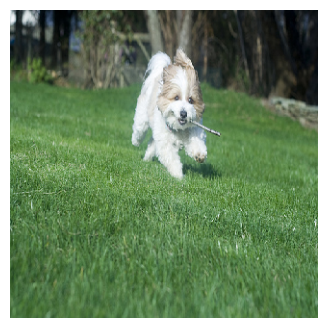

Запрос № 2
Введите запрос, для выхода наберите quit:girl playing on the field

------------------------------------------------------------------------
Запрос: girl playing on the field 

This image is unavailable in your country in compliance with local laws.

Запрос № 3
Введите запрос, для выхода наберите quit:man swimming

------------------------------------------------------------------------
Запрос: man swimming 



  0%|          | 0/1 [00:00<?, ?it/s]

4/4 [==============================] - 0s 5ms/step

Индекс соответствия по прогнозу модели: 0.6060838 



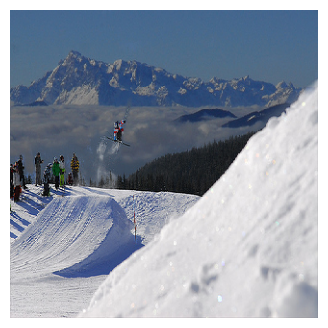

Запрос № 4
Введите запрос, для выхода наберите quit:quit
Ввод закончен


In [120]:
# проверка нейронной сети
rnd_query = ''
i=1
while True:
    print("Запрос №", i)
    rand_query = input("Введите запрос, для выхода наберите quit:")
    if rand_query == 'quit':
        print('Ввод закончен')
        break
    i=i+1
    img_by_text(rand_query)


Запрос № 1
Введите запрос, для выхода наберите quit:man in red

------------------------------------------------------------------------
Запрос: man in red 



  0%|          | 0/1 [00:00<?, ?it/s]


Индекс соответствия по прогнозу модели: 0.14825698894628067 



/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1019: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


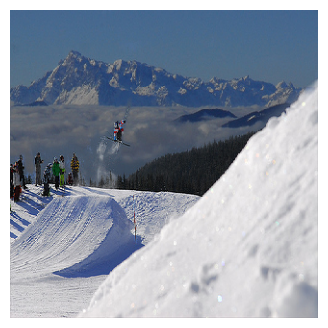

Запрос № 2
Введите запрос, для выхода наберите quit:women in black

------------------------------------------------------------------------
Запрос: women in black 



  0%|          | 0/1 [00:00<?, ?it/s]


Индекс соответствия по прогнозу модели: 0.1383335495656025 



/usr/local/lib/python3.10/dist-packages/lightgbm/basic.py:1019: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


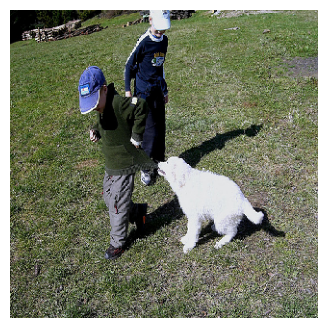

Запрос № 3
Введите запрос, для выхода наберите quit:quit
Ввод закончен


In [121]:
# проверка LGBModel модели
rnd_query = ''
i=1
while True:
    print("Запрос №", i)
    rand_query = input("Введите запрос, для выхода наберите quit:")
    if rand_query == 'quit':
        print('Ввод закончен')
        break
    i=i+1
    img_by_text(rand_query, model=LGBModel)


**Вывод:** Полученные модели плохо попадают в заспрос. Для повышения качества подбора картинки необходимо увеличить количество описаний для каждой картинки, то есть необходимо увеличение количество исходных данных.

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
В целом написанная тобой функция со своей задачей справляется. Принимают на вход текст и находят изображение. Отрабатывают контроль "запрещенного контента", выводят метрику близости.

Да, ты прав, к сожалению работают они не очень. И причин тут несколько - мало данных, не очень правильный подход.
    
Но справедливости ради должен заметить, что модель работает лучше чем просто "рандомная картинка". Если в описании собака,то как правило выводится изображение собаки.      
    
На мой взгляд более перспективным было бы привести ембеддинги изображений и текстов к одной размерности в одно пространство (через обучаемые слои) и в качестве меры близости использовать косинусное расстояние.
</div>

<img src="http://s3.amazonaws.com/pix.iemoji.com/images/emoji/apple/ios-12/256/waving-hand.png" align=left width=44, heigth=44>
<div class="alert alert-info">
<b> Комментарий ревьюера</b>
Неплохо работает следующий подход (к тому же легко реализуемый).
    
    
Вместо того, чтобы подавать на вход модели изображение + текст и получать меру соответствия, поступаем по другому.
    
На вход модели подаем вектор описания, а на выходе учимся предсказывать вектор изображения.
    
По поводу метрик тут ситуация следующая. Точно работает следующий подход
    
  - берем метрику mse, но тогда нужно чтобы модель её уменьшала. А значит в обучении используем только пары заведомо сответствующие друг другу

Можно попробовать использовать косинусное расстояние, она позволяет использовать все данные (если есть соответствие то выдает 1, если нет то 0).
    
Также можно попробовать усложнить модель, например и изображения и тексты отправлять в пространство размерностью 256 и уже в этом пространстве учиться их "сближать".
    
По поводу методов векторизации: я бы использовать resnet18 для изображений (размерность эмбеддинга избражения 512) и БЕРТ для текстов (768).    

</div>

<img src="http://s3.amazonaws.com/pix.iemoji.com/images/emoji/apple/ios-12/256/waving-hand.png" align=left width=44, heigth=44>
<div class="alert alert-info">
<b> Идеи и альтернативные подходы</b>
  Если хочешь получить хорошо работающее решение без обучения, то можешь провести эксперимент с нейронной сетью CLIP от OPEN AI (это не обязательно, только если хочешь добиться хороших результатов в этом проекте).

  Про эту нейронку много где написано, но можешь посмотреть например вот здесь  https://habr.com/ru/post/539312/.

  А для написания  реализации наиболее удобной лично для меня оказалась библиотека sbert. https://www.sbert.net/examples/applications/image-search/README.html  
    
    
</div>

- [x] Jupyter Notebook открыт
- [x] Весь код выполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Исследовательский анализ данных выполнен
- [x] Проверены экспертные оценки и краудсорсинговые оценки
- [x] Из датасета исключены те объекты, которые выходят за рамки юридических ограничений
- [x] Изображения векторизованы
- [x] Текстовые запросы векторизованы
- [x] Данные корректно разбиты на тренировочную и тестовую выборки
- [x] Предложена метрика качества работы модели
- [x] Предложена модель схожести изображений и текстового запроса
- [x] Модель обучена
- [x] По итогам обучения модели сделаны выводы
- [x] Проведено тестирование работы модели
- [x] По итогам тестирования визуально сравнили качество поиска

<img src="http://s3.amazonaws.com/pix.iemoji.com/images/emoji/apple/ios-12/256/waving-hand.png" align=left width=44, heigth=44>
<div class="alert alert-info">
<b> Заключительный комментарий</b>
Подведем итоги. Я вижу, что в целом с проектом ты справляешься.
    
Получены признаки из текста и изображений, обучены модели регрессии. Меня впечатлили серьезная проработка инструментов для подбора гиперпараметров, в частности использование keras tuner.
    
Скажу честно - я заметил, что некоторые куски кода были позаимствованы из работ других студентов, но учитывая глубокую степень переработки о плагиате вопрос абсолютно не стоит.    
    
    
Я оставил ряд красных комментариев, но они скорее формальные и много сил у тебя не отнимут.
    
Если есть желание, время и силы то можно попробовать доработать сам подход. Самым простым было бы запустить альтернативное решение через CLIP, также можно попробвоать обучить модель предскаывающую по вектору текста вектор изображения.
    
Желтые комментарии на твое усмотрение.
    
Жду твою работу на повторное ревью.
</div>